# Configuración del entorno

In [18]:
# Preparar espacio de trabajo

# Importaciones
import sys, os
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Montar Google Drive
mount_path = '/content/drive'
if not os.path.ismount(mount_path):
    drive.mount(mount_path)
    print("Google Drive montado.")
else:
    print("Google Drive ya está montado.")

# Crear carpeta principal
%cd /content/drive/MyDrive
os.makedirs("IA-DeteccionFraude", exist_ok=True)

# Cambiar el directorio de trabajo.
%cd /content/drive/MyDrive/IA-DeteccionFraude

# Crear la estructura de carpetas si no existe, siguiendo las buenas prácticas.
os.makedirs("src", exist_ok=True)       # Código fuente
os.makedirs("notebooks", exist_ok=True) # Cuadernos de Jupyter
os.makedirs("data", exist_ok=True)      # Datos crudos y procesados
os.makedirs("results", exist_ok=True)   # Gráficos y resultados de experimentos
os.makedirs("docs", exist_ok=True)      # Documentación y reportes

Google Drive ya está montado.
/content/drive/MyDrive
/content/drive/MyDrive/IA-DeteccionFraude


# Implementación de la red neuronal

In [19]:
## Crear archivo
%%writefile src/neural_network.py

from __future__ import annotations
from typing import List, Sequence, Dict, Tuple, Callable, Optional
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score

# Funciones de Activación y sus Derivadas
def sigmoid(z: np.ndarray) -> np.ndarray:
    """Implementación de la función de activación Sigmoid, estable numéricamente."""
    z_clip = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z_clip))

def dsigmoid(a: np.ndarray) -> np.ndarray:
    """Derivada de Sigmoid en términos de la salida 'a'."""
    return a * (1.0 - a)

def relu(z: np.ndarray) -> np.ndarray:
    """Implementación de la función de activación Rectified Linear Unit (ReLU)."""
    return np.maximum(0.0, z)

def drelu(z: np.ndarray, a: Optional[np.ndarray] = None) -> np.ndarray:
    """Derivada de ReLU en función de 'z': 1 si z>0, 0 en caso contrario."""
    g = np.zeros_like(z)
    g[z > 0] = 1.0
    return g

def tanh(z: np.ndarray) -> np.ndarray:
    """Implementación de la función de activación Tanh."""
    return np.tanh(z)

def dtanh(a: np.ndarray) -> np.ndarray:
    """Derivada de Tanh en términos de la salida 'a'."""
    return 1.0 - np.power(a, 2)

# Mapa de Funciones y la Clase NeuralNetwork

# Diccionario para mapear nombres de activación a sus funciones y derivadas.
_ACT_FUNCS: Dict[str, Tuple[Callable[[np.ndarray], np.ndarray], Callable[..., np.ndarray]]] = {
    "sigmoid": (sigmoid, dsigmoid),
    "relu": (relu, drelu),
    "tanh": (tanh, dtanh),
}

# Funciones de inicialización de pesos para evitar el vanishing/exploding gradient.
def _he_std(fan_in: int) -> float:
    """Inicialización He para ReLU: N(0, sqrt(2/fan_in))."""
    return np.sqrt(2.0 / fan_in)

def _xavier_std(fan_in: int) -> float:
    """Inicialización Xavier/Glorot para sigmoid/tanh: N(0, sqrt(1/fan_in))."""
    return 1.0 / np.sqrt(fan_in)

class NeuralNetwork:
    """
    Red neuronal totalmente conectada (MLP) implementada desde cero con NumPy.
    Soporta:
    - Múltiples capas ocultas.
    - Activaciones configurables por capa (Sigmoid, ReLU, Tanh).
    - Entrenamiento por gradiente descendente (full-batch).
    - Pérdida MSE para la regla delta.
    - Métricas de evaluación para clasificación binaria.
    """
    def __init__(self, layers: Sequence[int], activations: Optional[Sequence[str]] = None, seed: Optional[int] = 42):
        assert len(layers) >= 3, "La arquitectura debe tener al menos una capa de entrada, una oculta y una de salida."
        self.layers = list(layers)
        self.L = len(layers) - 1

        if activations is None:
            self.activations = ["relu"] * (self.L - 1) + ["sigmoid"]
        else:
            assert len(activations) == self.L, "El número de activaciones debe ser igual al número de capas con pesos (len(layers) - 1)."
            self.activations = [a.lower() for a in activations]

        for a in self.activations:
            assert a in _ACT_FUNCS, f"Activación desconocida: {a}"

        self.rng = np.random.default_rng(seed)
        self.W: List[np.ndarray] = []
        self.b: List[np.ndarray] = []
        self._init_params()

    def _init_params(self) -> None:
        """
        Inicializa los pesos (W) y sesgos (b) de la red.
        Usa la inicialización de He para ReLU y Xavier para otras activaciones.
        """
        self.W.clear()
        self.b.clear()
        for l in range(self.L):
            fan_in = self.layers[l]
            fan_out = self.layers[l+1]
            act = self.activations[l]

            if act == "relu":
                std = _he_std(fan_in)
            else:
                std = _xavier_std(fan_in)

            W_l = self.rng.normal(loc=0.0, scale=std, size=(fan_in, fan_out)).astype(np.float64)
            b_l = np.zeros((1, fan_out), dtype=np.float64)
            self.W.append(W_l)
            self.b.append(b_l)

    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, Dict[str, List[np.ndarray]]]:
        """
        Propagación hacia adelante: calcula las salidas de cada capa.
        Retorna: la predicción final y un caché de los valores 'Z' y 'A' para el backprop.
        """
        A = X
        A_list = [A]
        Z_list = []

        for l in range(self.L):
            Z = A @ self.W[l] + self.b[l]
            act, _ = _ACT_FUNCS[self.activations[l]]
            A = act(Z)
            Z_list.append(Z)
            A_list.append(A)

        cache = {"A": A_list, "Z": Z_list}
        return A, cache

    def _loss_mse(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        """Calcula la pérdida de error cuadrático medio (MSE)."""
        return float(np.mean(np.square(y_pred - y_true)))

    def _dA_mse(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        """Calcula el gradiente inicial de la pérdida con respecto a la salida."""
        m = y_true.shape[0]
        return (2.0 / m) * (y_pred - y_true)

    def backward(self, cache: Dict[str, List[np.ndarray]], y_true: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        Backpropagation: calcula los gradientes (dW y db) para todas las capas.
        Utiliza la regla delta para propagar el error hacia atrás.
        """
        A_list = cache["A"]
        Z_list = cache["Z"]

        dW_list = [None] * self.L
        db_list = [None] * self.L

        # Gradiente inicial en la capa de salida
        dA = self._dA_mse(A_list[-1], y_true)

        # Bucle para propagar hacia atrás (de la última capa a la primera)
        for l in reversed(range(self.L)):
            A_prev = A_list[l]
            Z = Z_list[l]
            act_name = self.activations[l]

            _, dact = _ACT_FUNCS[act_name]

            # Cálculo del gradiente local de la activación
            if act_name == "relu":
                dZ = dA * dact(z=Z)
            else:
                A_curr = A_list[l + 1]
                dZ = dA * dact(a=A_curr)

            # Cálculo de los gradientes de pesos y sesgos
            dW = A_prev.T @ dZ
            db = np.sum(dZ, axis=0, keepdims=True)

            # Propagación del gradiente a la capa anterior
            dA = dZ @ self.W[l].T

            dW_list[l] = dW
            db_list[l] = db

        return dW_list, db_list

    def train(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000, learning_rate: float = 0.01, verbose: bool = True) -> List[float]:
        """
        Entrena la red neuronal usando el algoritmo de descenso de gradiente (full-batch).
        Retorna la lista de pérdidas por cada época.
        """
        history = []
        for ep in range(1, epochs + 1):
            y_pred, cache = self.forward(X)
            loss = self._loss_mse(y_pred, y)
            dW_list, db_list = self.backward(cache, y)

            # Actualizar los pesos y sesgos
            for l in range(self.L):
                self.W[l] -= learning_rate * dW_list[l]
                self.b[l] -= learning_rate * db_list[l]

            history.append(loss)
            if verbose and (ep % max(1, epochs // 10) == 0 or ep == 1):
                print(f"[{ep:4d}/{epochs}] loss={loss:.6f}")

        return history

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Realiza una predicción hacia adelante en la red."""
        y_pred, _ = self.forward(X)
        return y_pred

    def accuracy(self, X: np.ndarray, y: np.ndarray, threshold: float = 0.5) -> float:
        """Calcula la precisión (accuracy) binaria del modelo."""
        y_hat = self.predict(X)
        y_bin = (y_hat >= threshold).astype(np.float64)
        return float(np.mean(y_bin == y))

    def get_performance_metrics(self, X: np.ndarray, y_true: np.ndarray, threshold: float = 0.5) -> dict:
        """
        Calcula las métricas de rendimiento clave (precisión, recall, F1-Score, matriz de confusión)
        para una clasificación binaria.
        """
        y_pred_proba = self.predict(X)
        y_pred_binary = (y_pred_proba >= threshold).astype(np.int64)
        y_true = y_true.ravel()

        cm = confusion_matrix(y_true, y_pred_binary)
        # Asegurarse de que la matriz de confusión tiene 4 elementos (2x2)
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        f1 = f1_score(y_true, y_pred_binary, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred_binary)
        precision = precision_score(y_true, y_pred_binary, zero_division=0)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': sensitivity,
            'specificity': specificity,
            'f1_score': f1,
            'confusion_matrix': cm
        }

    def threshold_optimization(self, X: np.ndarray, y_true: np.ndarray) -> tuple:
        """
        Encuentra el umbral óptimo que maximiza el F1-Score en el conjunto de datos.
        Retorna el umbral óptimo y el diccionario de métricas correspondiente.
        """
        y_pred_proba = self.predict(X)
        thresholds = np.linspace(0, 1, 101) # Probar 101 umbrales de 0 a 1
        best_f1 = -1
        best_threshold = 0.5
        best_metrics = {}

        for threshold in thresholds:
            metrics = self.get_performance_metrics(X, y_true, threshold)
            if metrics['f1_score'] > best_f1:
                best_f1 = metrics['f1_score']
                best_threshold = threshold
                best_metrics = metrics

        return best_threshold, best_metrics

Writing src/neural_network.py


# Prueba de la red con el problema XOR

In [20]:
# Importamos la clase NeuralNetwork del archivo que acabamos de crear.
sys.path.append(os.path.abspath("src"))
from neural_network import NeuralNetwork

# Dataset XOR: 4 muestras, 2 características de entrada.
X = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float64)
y = np.array([[0], [1], [1], [0]], dtype=np.float64)

# Definir la arquitectura de la red para resolver XOR: 2 entradas -> 8 neuronas -> 4 neuronas -> 1 salida.
layers = [2, 8, 4, 1]
activations = ["tanh", "tanh", "sigmoid"]
nn = NeuralNetwork(layers=layers, activations=activations, seed=0)

# Entrenar la red. Se usa verbose=False para no imprimir el progreso en cada época.
history = nn.train(X, y, epochs=5000, learning_rate=0.1, verbose=False)

# Mostrar los resultados del entrenamiento.
print("Loss inicial:", round(history[0], 6))
print("Loss final:", round(history[-1], 6))
print("Accuracy:", nn.accuracy(X, y))
print("Predicciones:", np.round(nn.predict(X), 3).ravel())

Loss inicial: 0.252373
Loss final: 0.000591
Accuracy: 1.0
Predicciones: [0.015 0.971 0.97  0.02 ]


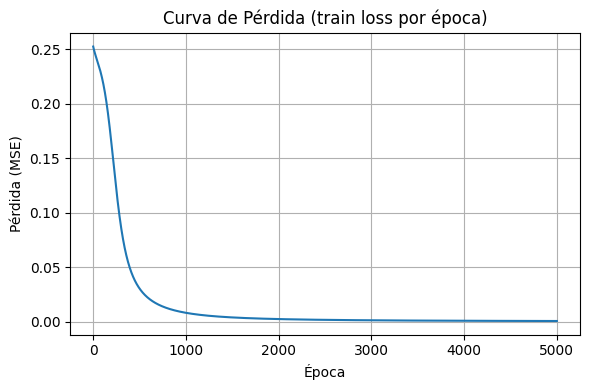

In [21]:
# Graficar la pérdida por época

# history es la lista de pérdidas que devolvió nn.train(...).
loss = np.array(history, dtype=float)
plt.figure(figsize=(6, 4))
plt.plot(loss)
plt.title("Curva de Pérdida (train loss por época)")
plt.xlabel("Época")
plt.ylabel("Pérdida (MSE)")
plt.grid(True)
plt.tight_layout()

# Guardar el gráfico en la carpeta de resultados.
plt.savefig("results/training_curves_xor.png")
plt.show()

# Generar datos sintéticos

In [22]:
# Generar datos sintéticos para el proyecto de fraude

# Semilla
np.random.seed(42)
n = 50000

# Generación de variables numéricas con distribuciones realistas.
monto = np.random.exponential(scale=100, size=n)
hora = np.random.randint(0, 24, size=n)
n_transacciones_1h = np.random.poisson(lam=2, size=n)
score_riesgo = np.random.rand(n) * 100
tiempo_ultima_transaccion = np.random.exponential(scale=300, size=n)

# Generación de variables categóricas.
paises = ['EC', 'US', 'BR', 'MX', 'CO']
dispositivos = ['Android', 'iOS', 'Web']
pais = np.random.choice(paises, size=n, p=[0.3, 0.25, 0.2, 0.15, 0.1])
dispositivo = np.random.choice(dispositivos, size=n, p=[0.5, 0.3, 0.2])

# Inyección del fraude (0.1% de las transacciones)
fraude = np.zeros(n)
fraude_idx = np.random.choice(n, size=int(n * 0.001), replace=False)
fraude[fraude_idx] = 1
monto[fraude_idx] *= 10 # Los montos fraudulentos son mucho mayores

# Crear DataFrame y guardar en la carpeta 'data'.
df = pd.DataFrame({
    'monto': monto, 'hora': hora, 'n_transacciones_1h': n_transacciones_1h,
    'tiempo_ultima_transaccion': tiempo_ultima_transaccion, 'score_riesgo': score_riesgo,
    'pais': pais, 'dispositivo': dispositivo, 'fraude': fraude
})
df.to_csv('data/datos_sinteticos_fraude.csv', index=False)